In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
8/8 [==============================] - 0s 51ms/step - loss: 107.3070 - mae: 107.8067
Epoch 2/10
8/8 [==============================] - 0s 44ms/step - loss: 106.5453 - mae: 107.0451
Epoch 3/10
8/8 [==============================] - 0s 42ms/step - loss: 105.3273 - mae: 105.8269
Epoch 4/10
8/8 [==============================] - 0s 40ms/step - loss: 103.7962 - mae: 104.2958
Epoch 5/10
8/8 [==============================] - 0s 45ms/step - loss: 102.0092 - mae: 102.5088
Epoch 6/10
8/8 [==============================] - 0s 42ms/step - loss: 99.9592 - mae: 100.4588
Epoch 7/10
8/8 [==============================] - 0s 47ms/step - loss: 97.6531 - mae: 98.1528
Epoch 8/10
8/8 [==============================] - 0s 42ms/step - loss: 95.0574 - mae: 95.5570
Epoch 9/10
8/8 [==============================] - 0s 43ms/step - loss: 92.1446 - mae: 92.6441
Epoch 10/10
8/8 [==============================] - 0s 43ms/step - loss: 88.8601 - mae: 89.3596


(1e-08, 0.0001, 0.0, 30.0)

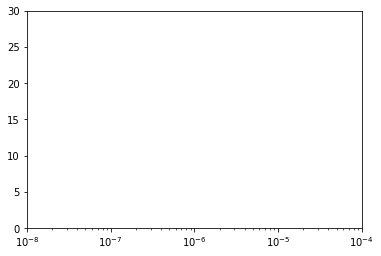

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(50, return_sequences=True),
  tf.keras.layers.LSTM(50, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 25ms/step - loss: 7.8252 - mae: 8.3087
Epoch 2/500
31/31 [==============================] - 1s 22ms/step - loss: 5.4516 - mae: 5.9302
Epoch 3/500
31/31 [==============================] - 1s 22ms/step - loss: 5.1516 - mae: 5.6290
Epoch 4/500
31/31 [==============================] - 1s 22ms/step - loss: 5.0998 - mae: 5.5789
Epoch 5/500
31/31 [==============================] - 1s 22ms/step - loss: 5.0455 - mae: 5.5236
Epoch 6/500
31/31 [==============================] - 1s 22ms/step - loss: 5.1030 - mae: 5.5819
Epoch 7/500
31/31 [==============================] - 1s 22ms/step - loss: 4.8890 - mae: 5.3675
Epoch 8/500
31/31 [==============================] - 1s 22ms/step - loss: 4.7778 - mae: 5.2560
Epoch 9/500
31/31 [==============================] - 1s 23ms/step - loss: 4.8072 - mae: 5.2847
Epoch 10/500
31/31 [==============================] - 1s 22ms/step - loss: 4.7938 - mae: 5.2720
Epoch 11/500
31/31 [=============================

31/31 [==============================] - 1s 27ms/step - loss: 4.1597 - mae: 4.6337
Epoch 87/500
31/31 [==============================] - 1s 24ms/step - loss: 4.2037 - mae: 4.6793
Epoch 88/500
31/31 [==============================] - 1s 23ms/step - loss: 4.1239 - mae: 4.5979
Epoch 89/500
31/31 [==============================] - 1s 23ms/step - loss: 4.1016 - mae: 4.5759
Epoch 90/500
31/31 [==============================] - 1s 23ms/step - loss: 4.0940 - mae: 4.5674
Epoch 91/500
31/31 [==============================] - 1s 25ms/step - loss: 4.1245 - mae: 4.5981
Epoch 92/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0961 - mae: 4.5707
Epoch 93/500
31/31 [==============================] - 1s 23ms/step - loss: 4.0812 - mae: 4.5547
Epoch 94/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0979 - mae: 4.5707
Epoch 95/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0668 - mae: 4.5402
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 24ms/step - loss: 4.0333 - mae: 4.5078
Epoch 171/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9829 - mae: 4.4564
Epoch 172/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9970 - mae: 4.4701
Epoch 173/500
31/31 [==============================] - 1s 24ms/step - loss: 3.9781 - mae: 4.4506
Epoch 174/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9882 - mae: 4.4610
Epoch 175/500
31/31 [==============================] - 1s 22ms/step - loss: 4.0360 - mae: 4.5099
Epoch 176/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9953 - mae: 4.4690
Epoch 177/500
31/31 [==============================] - 1s 24ms/step - loss: 4.0125 - mae: 4.4866
Epoch 178/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9861 - mae: 4.4589
Epoch 179/500
31/31 [==============================] - 1s 23ms/step - loss: 4.0352 - mae: 4.5090
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 22ms/step - loss: 3.9360 - mae: 4.4087
Epoch 255/500
31/31 [==============================] - 1s 22ms/step - loss: 3.9866 - mae: 4.4596
Epoch 256/500
31/31 [==============================] - 1s 22ms/step - loss: 4.0279 - mae: 4.5018
Epoch 257/500
31/31 [==============================] - 1s 22ms/step - loss: 3.9860 - mae: 4.4595
Epoch 258/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9987 - mae: 4.4717
Epoch 259/500
31/31 [==============================] - 1s 22ms/step - loss: 3.9252 - mae: 4.3979
Epoch 260/500
31/31 [==============================] - 1s 23ms/step - loss: 4.0517 - mae: 4.5250
Epoch 261/500
31/31 [==============================] - 1s 24ms/step - loss: 3.9714 - mae: 4.4437
Epoch 262/500
31/31 [==============================] - 1s 25ms/step - loss: 3.9570 - mae: 4.4301
Epoch 263/500
31/31 [==============================] - 1s 25ms/step - loss: 3.9685 - mae: 4.4420
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 23ms/step - loss: 3.9767 - mae: 4.4485
Epoch 339/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9385 - mae: 4.4108
Epoch 340/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9313 - mae: 4.4034
Epoch 341/500
31/31 [==============================] - 1s 24ms/step - loss: 3.9351 - mae: 4.4071
Epoch 342/500
31/31 [==============================] - 1s 24ms/step - loss: 3.9130 - mae: 4.3850
Epoch 343/500
31/31 [==============================] - 1s 23ms/step - loss: 3.8953 - mae: 4.3678
Epoch 344/500
31/31 [==============================] - 1s 24ms/step - loss: 3.9538 - mae: 4.4257
Epoch 345/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9372 - mae: 4.4096
Epoch 346/500
31/31 [==============================] - 1s 24ms/step - loss: 3.8857 - mae: 4.3578
Epoch 347/500
31/31 [==============================] - 1s 27ms/step - loss: 3.9241 - mae: 4.3958
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 29ms/step - loss: 3.8605 - mae: 4.3323
Epoch 423/500
31/31 [==============================] - 1s 26ms/step - loss: 3.8722 - mae: 4.3442
Epoch 424/500
31/31 [==============================] - 1s 24ms/step - loss: 3.8788 - mae: 4.3507
Epoch 425/500
31/31 [==============================] - 1s 25ms/step - loss: 3.8948 - mae: 4.3665
Epoch 426/500
31/31 [==============================] - 1s 23ms/step - loss: 3.9142 - mae: 4.3864
Epoch 427/500
31/31 [==============================] - 1s 22ms/step - loss: 3.9302 - mae: 4.4017
Epoch 428/500
31/31 [==============================] - 1s 22ms/step - loss: 3.9543 - mae: 4.4259
Epoch 429/500
31/31 [==============================] - 1s 28ms/step - loss: 3.8894 - mae: 4.3617
Epoch 430/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9148 - mae: 4.3858
Epoch 431/500
31/31 [==============================] - 1s 24ms/step - loss: 3.8563 - mae: 4.3276
Epoch 432/500
31/31 [=======================

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

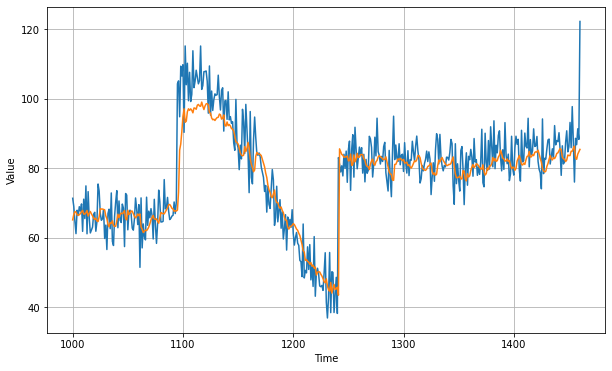

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0940323

<Figure size 432x288 with 0 Axes>

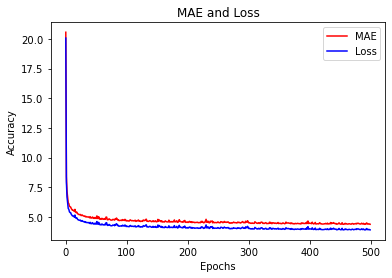

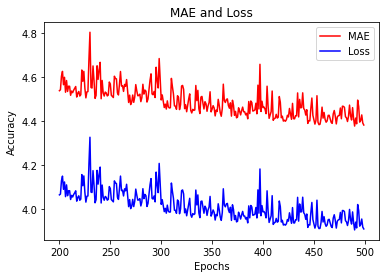

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()